# A signal processing approach - low pass filtering

Due to the nature of the signal data we have been provided, a signal processing approach can provide advantages. In short, it can help us decouple the signal from the noise in order to provide our models with a less noisy signal. In this kernel I will be performing the following on each batch:
1. Analyze frequency domain characteristics
2. Characterize Signal-To-Noise Ratio (SNR) of the data
3. Based on SNR, apply low pass filter to reduce signal noise
4. Perform feature engineering and apply models based on filtered signal

#### I am using the data without drift dataset for this kernel: https://www.kaggle.com/cdeotte/data-without-drift

### If you find this kernel useful, please upvote!


In [1]:
!pip install catboost

     |████████████████████████████████| 64.4MB 47kB/s 


In [2]:
!ls "./drive/My Drive/Colab Notebooks/liverpool-ion-switching"


ls: cannot access './drive/My Drive/Colab Notebooks/liverpool-ion-switching': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt,freqz
from sklearn import *
from sklearn.metrics import f1_score
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool,CatBoostRegressor
import time
import datetime
from sklearn.model_selection import KFold


# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [5]:
train = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean.csv')
test = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_clean.csv')
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [0]:
batch_size = 500000
num_batches = 10
res = 1000 # Resolution of signal plots

fs = 10000       # sample rate, 10kHz
nyq = 0.5 * fs  # Nyquist Frequency
cutoff_freq_sweep = range(250,4750,50) # Sweeping from 250 to 4750 Hz for SNR measurement
lpf_cutoff = 600

### This is a good visualization of the training data signal and open channels.

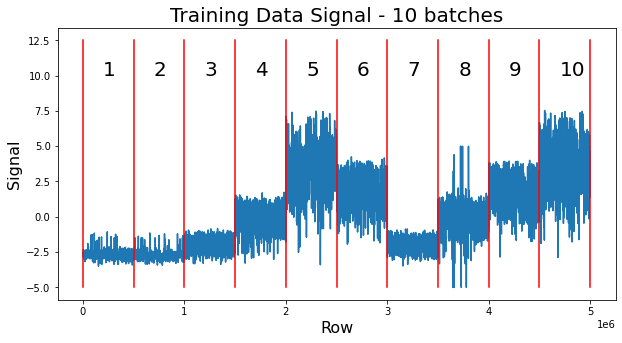

In [7]:
plt.figure(figsize=(10,5));
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(num_batches+1): plt.plot([i*batch_size,i*batch_size],[-5,12.5],'r')
for j in range(num_batches): plt.text(j*batch_size+200000,num_batches,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

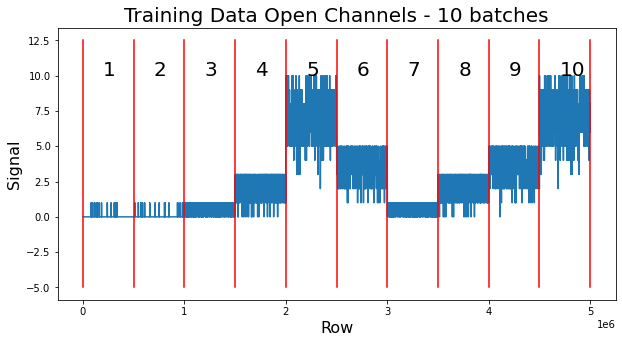

In [8]:
plt.figure(figsize=(10,5));
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(num_batches+1): plt.plot([i*batch_size,i*batch_size],[-5,12.5],'r')
for j in range(num_batches): plt.text(j*batch_size+200000,num_batches,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Open Channels - 10 batches',size=20)
plt.show()

### The following functions can be used to create a high-pass, low-pass, or band-pass butterworth filter as well as measure SNR. I only used the low-pass filter in this kernel, but highly encourage others to experiment with different filter configurations.

In [0]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, cutoff_low, cuttoff_high, fs, order):
    normal_cutoff_low = cutoff_low / nyq
    normal_cutoff_high = cutoff_high / nyq    
    # Get the filter coefficients 
    b, a = butter(order, [normal_cutoff_low,normal_cutoff_high], btype='band', analog=False)
    y = filtfilt(b, a, data)
    return y

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

# Frequency Domain Analysis

### First off, we want to better understand the frequency content within each batch. We notice that there is considerable broadband noise and it isn't clear from this that there is a predominant frequency that differentiates the signal. There are some batches that have some interesting features at the low frequencies (Batch 1 and 2). There also appears to be some interesting noise scatter amonst higher frequencies in batch 8. Based on this, we may be able to attenuate a large portion of the higher frequencies to reduce signal noise. We will do this by applying a low-pass filter.

/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])
/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])
/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])
/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])
/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x,

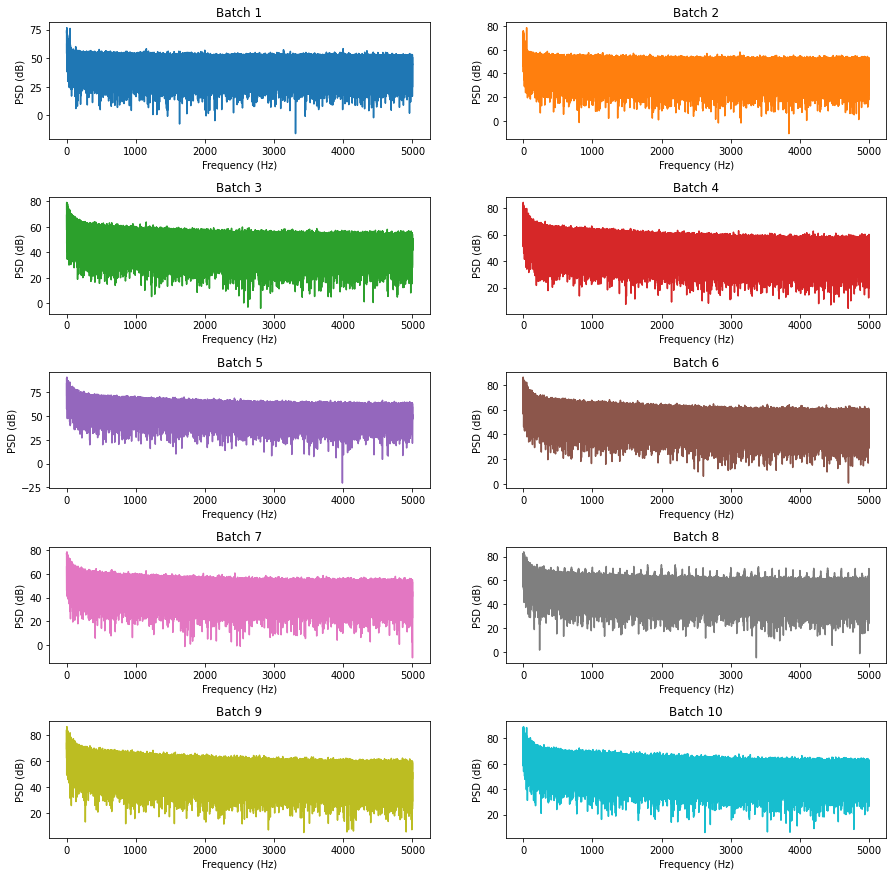

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace = .5)
ax = ax.ravel()
colors = plt.rcParams["axes.prop_cycle"]()

for batch in range(num_batches):
    fft = sp.fftpack.fft(train.signal[batch_size*(batch):batch_size*(batch+1)])
    psd = np.abs(fft) ** 2
    fftfreq = sp.fftpack.fftfreq(len(psd),1/fs)
    i = fftfreq > 0
    
    c = next(colors)["color"]
    ax[batch].plot(fftfreq[i], 10 * np.log10(psd[i]),color=c)
    ax[batch].set_title(f'Batch {batch+1}')
    ax[batch].set_xlabel('Frequency (Hz)')
    ax[batch].set_ylabel('PSD (dB)')

# Signal-to-Noise (SNR) Characterization 

### We can apply low-pass filters with different cutoff frequencies in order to see at which cutoff frequency our signal begins to degrade. It looks like a cutoff frequency of 600Hz provides us with the best SNR for most batches. One thing to note is that the SNR for different batches is either positive or negative. Typically, a negative SNR means our noise is greater than our signal. However, I will show later that this isn't actual the case with some of our batches. 

**Positive SNR:** Batch 4, Batch 5, Batch 6, Batch 9, Batch 10

**Negative SNR:** Batch 1, Batch 2, Batch 3, Batch 7, Batch 8

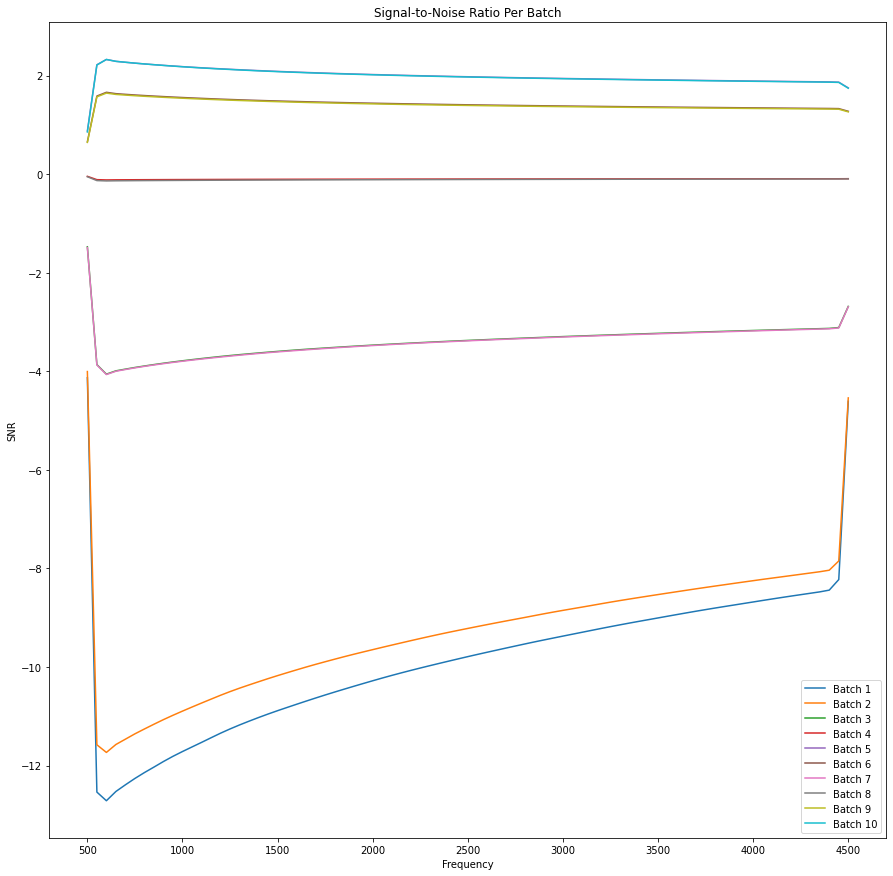

In [11]:
plt.figure(figsize=(15,15));

# Filter requirements.
order = 20  
SNR = np.zeros(len(cutoff_freq_sweep))

for batch in range(num_batches):
    for index,cut in enumerate(cutoff_freq_sweep): 
        signal_lpf = butter_lowpass_filter(train.signal[batch_size*(batch):batch_size*(batch+1)], cut, fs, order)
        SNR[index] = signaltonoise(signal_lpf)
    
    plt.plot(cutoff_freq_sweep,SNR)

plt.title('Signal-to-Noise Ratio Per Batch')    
plt.xlabel('Frequency')
plt.ylabel('SNR')
plt.legend(['Batch 1','Batch 2','Batch 3','Batch 4','Batch 5','Batch 6','Batch 7','Batch 8','Batch 9','Batch 10',])

# Low Pass Filtering By Batch

### In case you are unfamiliar with filtering, I am plotting the the low pass filter design with a cutoff frequency at 600Hz below. Notice how we are not attenuating between 0 and 600Hz, i.e. we are allowing low frequencies to 'pass' unaffected by the filter. But anything above 600Hz will be attenuated as you can see by how the amplitude falls away all the way out to our Nyquist frequency.

Text(0.5, 1.0, 'Low-pass Butterworth Filter, cutoff @ 600Hz')

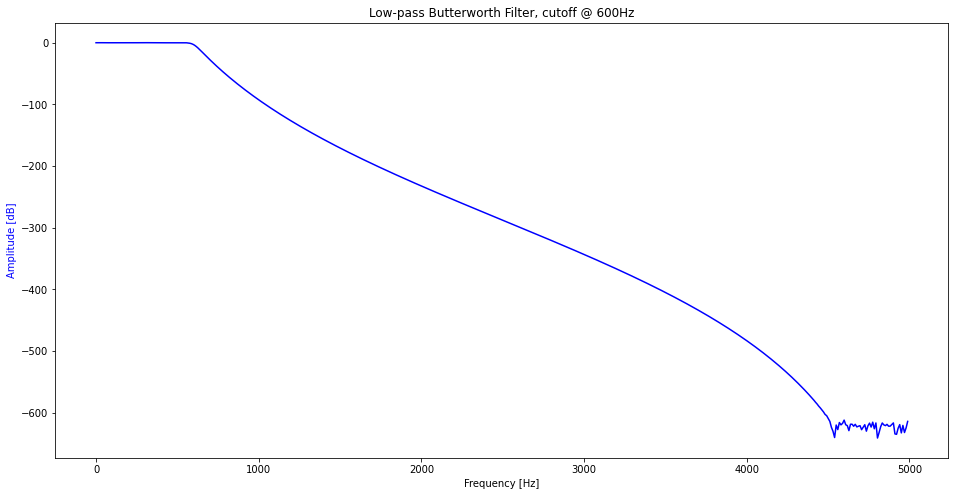

In [12]:
b, a = butter(order, lpf_cutoff/nyq, btype='low', analog=False)
w,h = freqz(b,a, fs=fs)

plt.figure(figsize=(16,8));
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.title('Low-pass Butterworth Filter, cutoff @ 600Hz')

### When we apply the filter to Batch 1, we see how our frequency response changes.

/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])


Text(0.5, 1.0, 'Low pass filter - cutoff = 600 Hz')

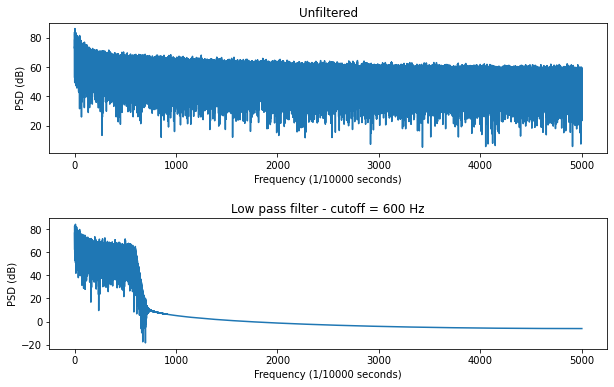

In [13]:
fft = sp.fftpack.fft(train.signal[batch_size*(batch-1):batch_size*batch])
psd = np.abs(fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(psd),1/fs)
i = fftfreq > 0

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
fig.subplots_adjust(hspace = .5)
ax[0].plot(fftfreq[i], 10 * np.log10(psd[i]))
ax[0].set_xlabel('Frequency (1/10000 seconds)')
ax[0].set_ylabel('PSD (dB)')
ax[0].set_title('Unfiltered')

batch = 8
signal_lpf_batch_8 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fft = sp.fftpack.fft(signal_lpf_batch_8)
psd = np.abs(fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(psd),1/fs)
i = fftfreq > 0

ax[1].plot(fftfreq[i], 10 * np.log10(psd[i]))
ax[1].set_xlabel('Frequency (1/10000 seconds)')
ax[1].set_ylabel('PSD (dB)')
ax[1].set_title('Low pass filter - cutoff = 600 Hz')

### Now we will apply this Low Pass Filter (LPF) to all batches and look at how that impacts the time domain signal.

## Batch 1

### We can see that our noise floor has been reduced significantly. We also see that some of the spikes have been reduced in amplitude a bit, but overall not nearly as much as our noise floor.

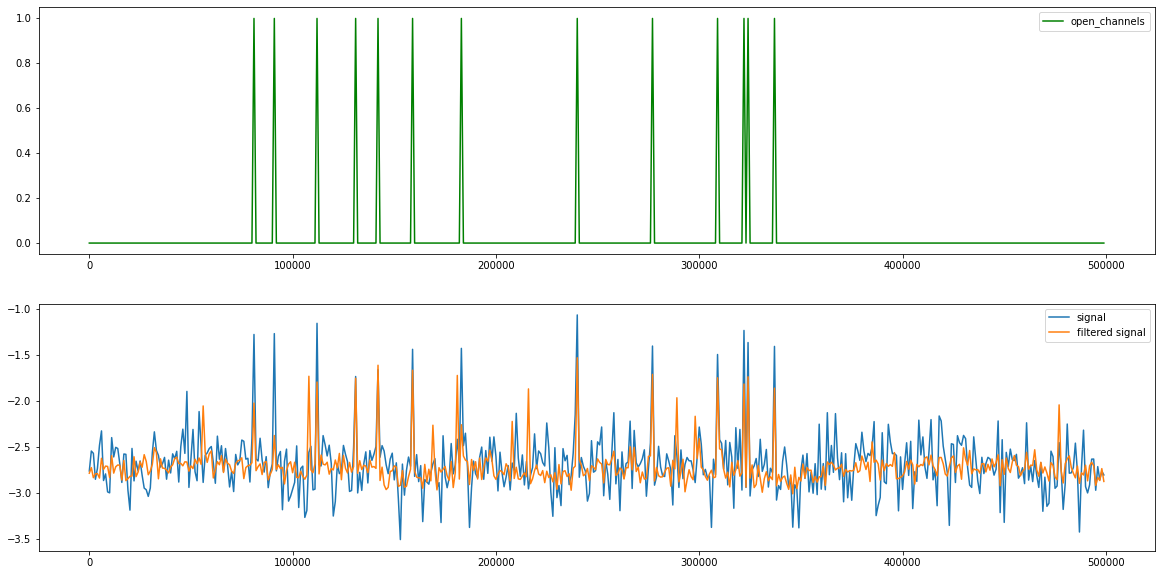

In [14]:
batch = 1

signal_lpf_batch_1 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_1[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Batch 2

### Same story as Batch 1, more signal and less noise

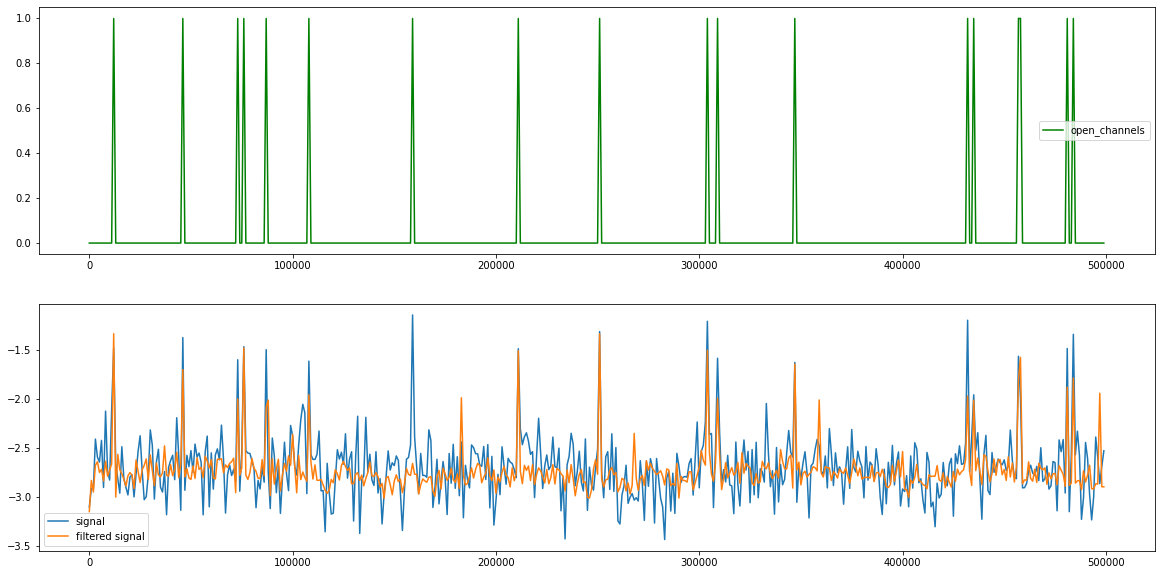

In [15]:
batch = 2

signal_lpf_batch_2 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_2[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Batch 3

### I think the LPF actually really helped with normalizing levels. Notice how now open_channel = 1 and it's associated levels in the filtered signal jump around much less than the unfiltered signal.

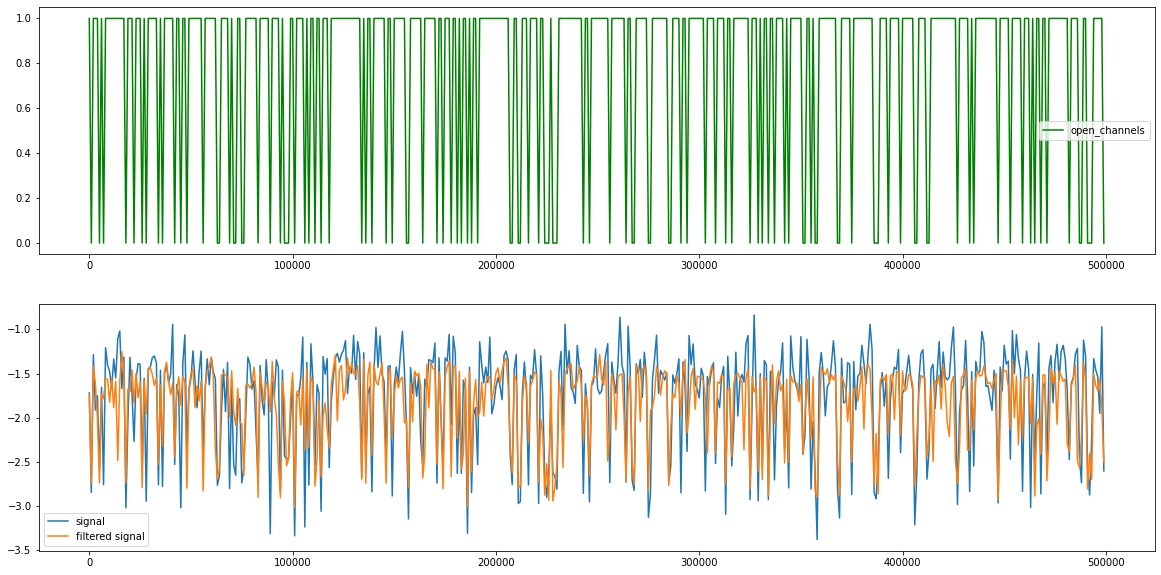

In [16]:
batch = 3

signal_lpf_batch_3 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_3[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Batch 4

### It isn't as clear whether the LPF helped out for this batch, but we will see when we check model performance

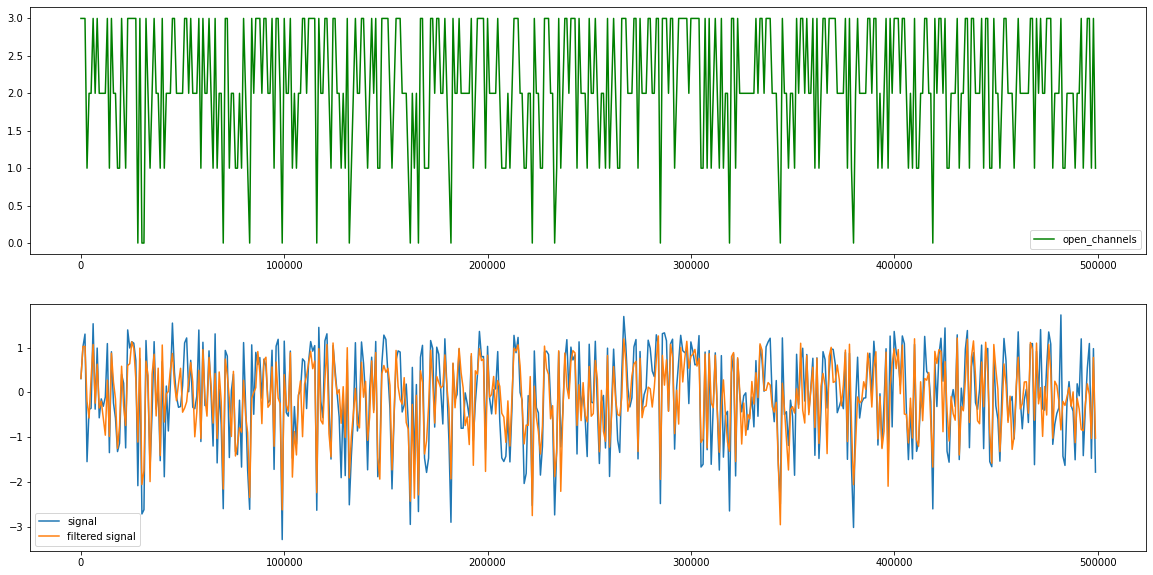

In [17]:
batch = 4

signal_lpf_batch_4 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_4[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Batch 5

### We may have lost some signal when filtering on this batch. 

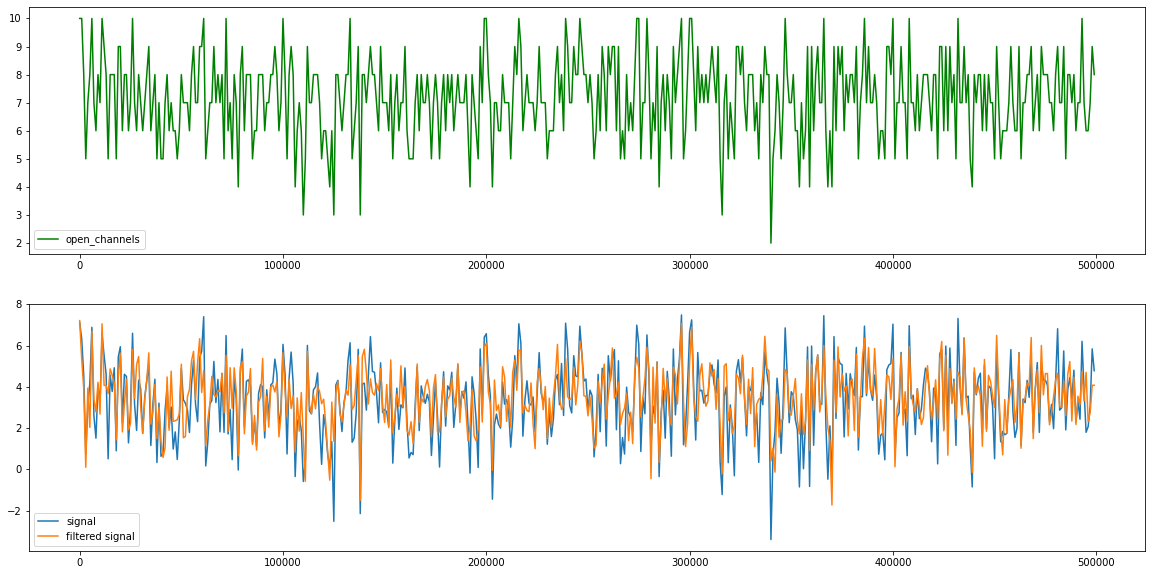

In [18]:
batch = 5

signal_lpf_batch_5 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_5[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Batch 6

### Same as Batch 5, we may have lost some signal in the filtering

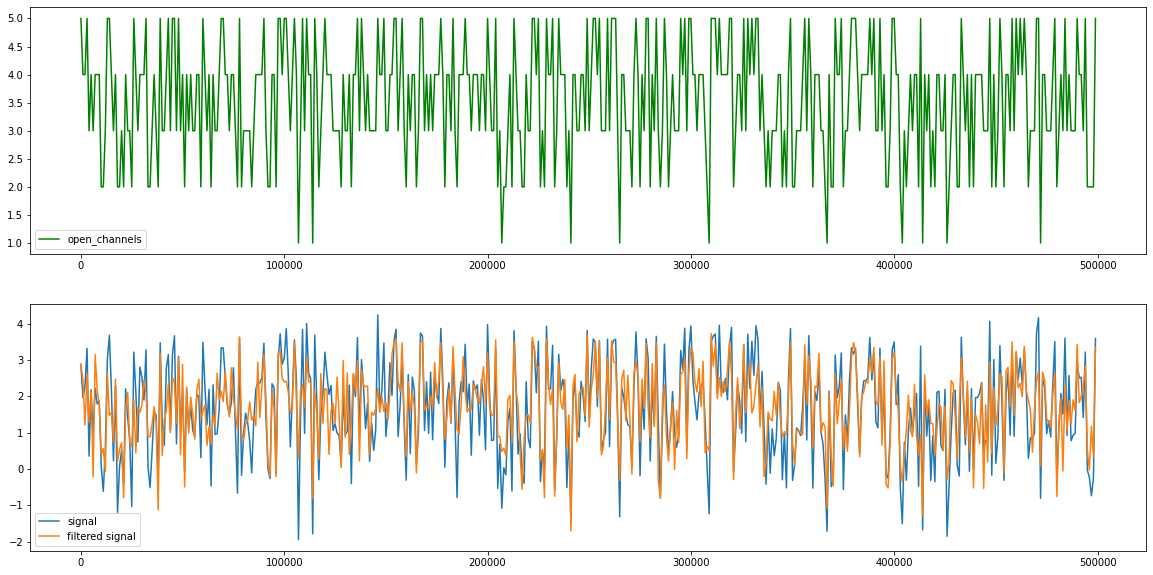

In [19]:
batch = 6

signal_lpf_batch_6 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_6[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Batch 7

### This looks a lot like Batch 3 where it is clear that filtering helped reduce noise.

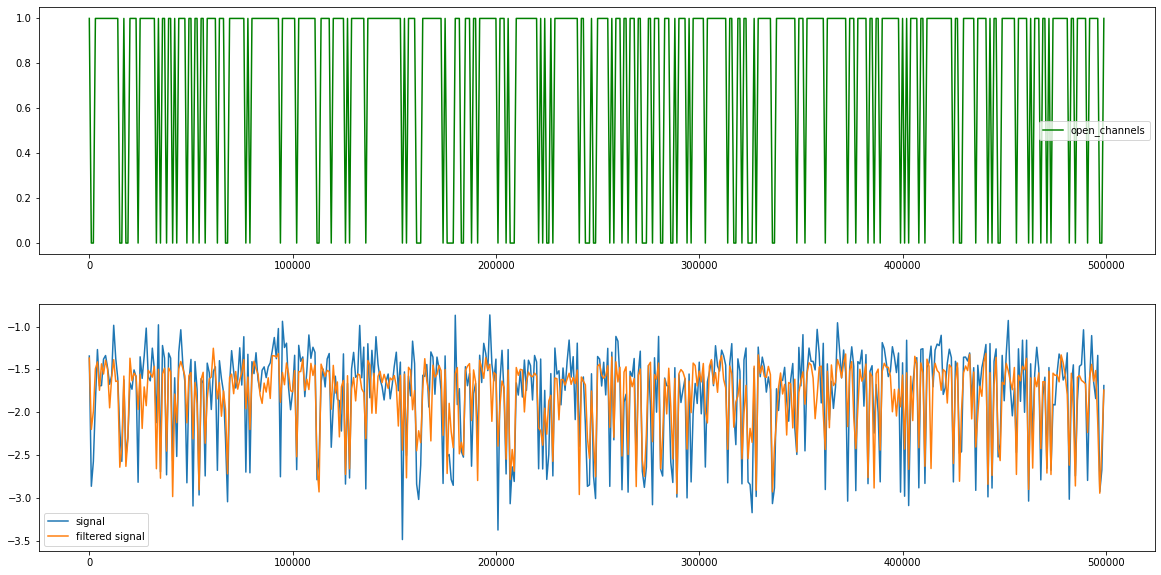

In [20]:
batch = 7

signal_lpf_batch_7 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_7[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Batch 8

### Batch 8 is unique in the sense that it looks like there was some measurement noise. The LPF was able to filter it out which will help us out a lot.

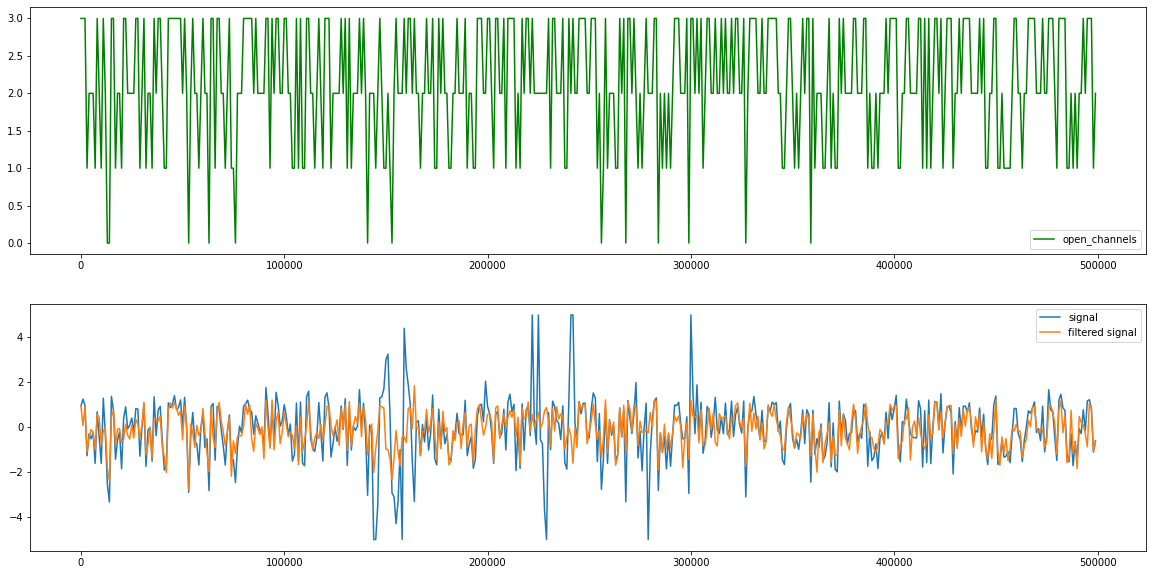

In [21]:
batch = 8

signal_lpf_batch_8 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_8[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Batch 9

### Unclear whether filtering helped or hurt

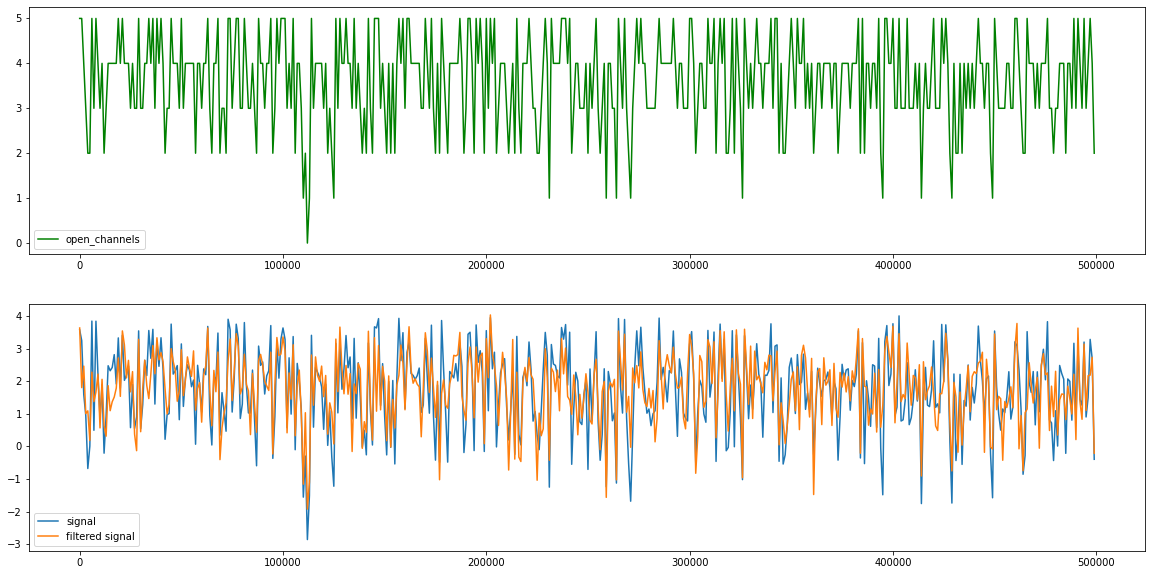

In [22]:
batch = 9

signal_lpf_batch_9 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_9[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Batch 10

### Unclear whether filtering helped or hurt

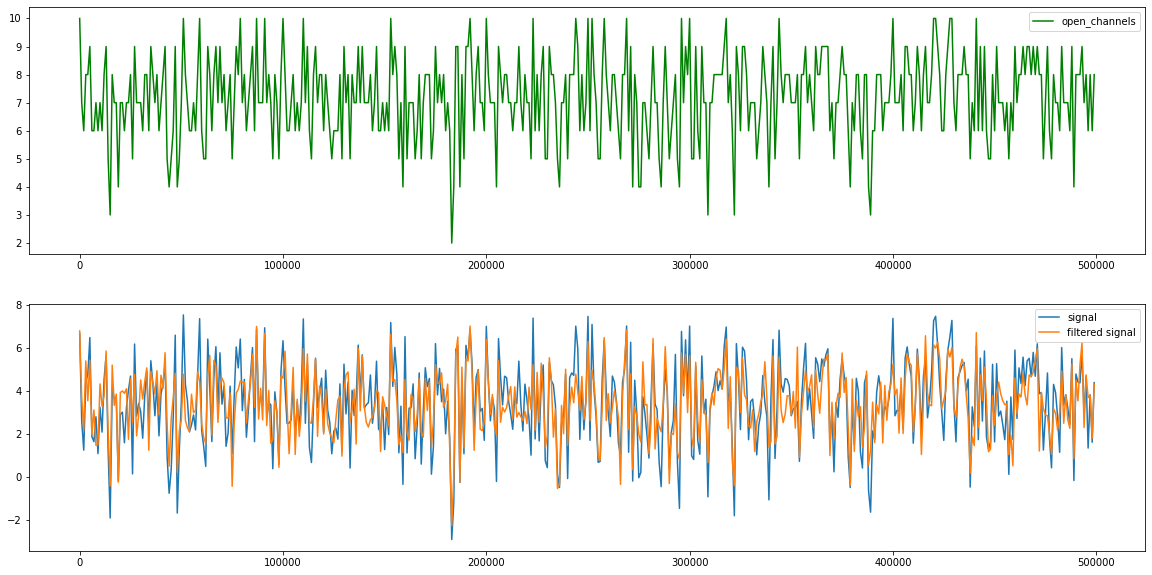

In [23]:
batch = 10

signal_lpf_batch_10 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_10[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

## Now just apply LPF to train and test data. We will start by applying our filter to one batch at a time, however we could see improvement by only applying the filter to batches we know were helped.

In [24]:
# Preprocess train data
batch = 8
train['signal'][batch_size*(batch-1):batch_size*batch] = signal_lpf_batch_8

# Train Data
train['signal_undrifted'] = train['signal']
# Test Data
test['signal_undrifted'] = test['signal']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Feature Engineering and Modeling

In [25]:
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal_undrifted'].mean()
        d['median'+c] = df.groupby([c])['signal_undrifted'].median()
        d['max'+c] = df.groupby([c])['signal_undrifted'].max()
        d['min'+c] = df.groupby([c])['signal_undrifted'].min()
        d['std'+c] = df.groupby([c])['signal_undrifted'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal_undrifted'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal_undrifted'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal_undrifted'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal_undrifted'].values[:-1])
    df['signal_shift_-1'] = list(df['signal_undrifted'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan

    # add shifts_2
    df['signal_shift_+2'] = [0,] + [1,] + list(df['signal_undrifted'].values[:-2])
    df['signal_shift_-2'] = list(df['signal_undrifted'].values[2:]) + [0] + [1]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+2'][i] = np.nan
    for i in df[df['batch_index']==1].index:
        df['signal_shift_+2'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-2'][i] = np.nan
    for i in df[df['batch_index']==49998].index:
        df['signal_shift_-2'][i] = np.nan 
        
    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal_undrifted', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal_undrifted']
        
    return df

train = features(train)
test = features(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be s

In [26]:
train.head()

,time,signal,open_channels,signal_undrifted,batch,batch_index,batch_slices,batch_slices2,meanbatch,medianbatch,maxbatch,minbatch,stdbatch,mean_abs_chgbatch,abs_maxbatch,abs_minbatch,rangebatch,maxtominbatch,abs_avgbatch,meanbatch_slices2,medianbatch_slices2,maxbatch_slices2,minbatch_slices2,stdbatch_slices2,mean_abs_chgbatch_slices2,abs_maxbatch_slices2,abs_minbatch_slices2,rangebatch_slices2,maxtominbatch_slices2,abs_avgbatch_slices2,signal_shift_+1,signal_shift_-1,signal_shift_+2,signal_shift_-2,signal_msignal,meanbatch_msignal,medianbatch_msignal,maxbatch_msignal,minbatch_msignal,stdbatch_msignal,mean_abs_chgbatch_msignal,abs_maxbatch_msignal,abs_minbatch_msignal,rangebatch_msignal,maxtominbatch_msignal,abs_avgbatch_msignal,meanbatch_slices2_msignal,medianbatch_slices2_msignal,maxbatch_slices2_msignal,minbatch_slices2_msignal,stdbatch_slices2_msignal,mean_abs_chgbatch_slices2_msignal,abs_maxbatch_slices2_msignal,abs_minbatch_slices2_msignal,rangebatch_slices2_msignal,maxtominbatch_slices2_msignal,abs_avgbatch_slices2_msignal,signal_shift_+1_msignal,signal_shift_-1_msignal,signal_shift_+2_msignal,signal_shift_-2_msignal
0.0,0.0001,-2.7600,0,-2.7600,0.0,0.0,0.0,0.0_0.0,-2.687195,-2.6926,-0.7651,-3.6621,0.260662,0.270291,3.6621,0.7651,2.897,0.208924,2.2136,-2.695613,-2.6944,-1.8626,-3.5896,0.242952,0.269729,3.5896,1.8626,1.727,0.518888,2.7261,NaN,-2.8557,NaN,-2.4074,0.0,0.072805,0.0674,1.9949,-0.9021,3.020662,3.030291,6.4221,3.5251,5.6570,2.968924,4.9736,0.064387,0.0656,0.8974,-0.8296,3.002952,3.029729,6.3496,4.6226,4.4870,3.278888,5.4861,NaN,-0.0957,NaN,0.3526
1.0,0.0002,-2.8557,0,-2.8557,0.0,1.0,0.0,0.0_0.0,-2.687195,-2.6926,-0.7651,-3.6621,0.260662,0.270291,3.6621,0.7651,2.897,0.208924,2.2136,-2.695613,-2.6944,-1.8626,-3.5896,0.242952,0.269729,3.5896,1.8626,1.727,0.518888,2.7261,-2.7600,-2.4074,NaN,-3.1404,0.0,0.168505,0.1631,2.0906,-0.8064,3.116362,3.125991,6.5178,3.6208,5.7527,3.064624,5.0693,0.160087,0.1613,0.9931,-0.7339,3.098652,3.125429,6.4453,4.7183,4.5827,3.374588,5.5818,0.0957,0.4483,NaN,-0.2847
2.0,0.0003,-2.4074,0,-2.4074,0.0,2.0,0.0,0.0_0.0,-2.687195,-2.6926,-0.7651,-3.6621,0.260662,0.270291,3.6621,0.7651,2.897,0.208924,2.2136,-2.695613,-2.6944,-1.8626,-3.5896,0.242952,0.269729,3.5896,1.8626,1.727,0.518888,2.7261,-2.8557,-3.1404,-2.7600,-3.1525,0.0,-0.279795,-0.2852,1.6423,-1.2547,2.668062,2.677691,6.0695,3.1725,5.3044,2.616324,4.6210,-0.288213,-0.2870,0.5448,-1.1822,2.650352,2.677129,5.9970,4.2700,4.1344,2.926288,5.1335,-0.4483,-0.7330,-0.3526,-0.7451
3.0,0.0004,-3.1404,0,-3.1404,0.0,3.0,0.0,0.0_0.0,-2.687195,-2.6926,-0.7651,-3.6621,0.260662,0.270291,3.6621,0.7651,2.897,0.208924,2.2136,-2.695613,-2.6944,-1.8626,-3.5896,0.242952,0.269729,3.5896,1.8626,1.727,0.518888,2.7261,-2.4074,-3.1525,-2.8557,-2.6418,0.0,0.453205,0.4478,2.3753,-0.5217,3.401062,3.410691,6.8025,3.9055,6.0374,3.349324,5.3540,0.444787,0.4460,1.2778,-0.4492,3.383352,3.410129,6.7300,5.0030,4.8674,3.659288,5.8665,0.7330,-0.0121,0.2847,0.4986
4.0,0.0005,-3.1525,0,-3.1525,0.0,4.0,0.0,0.0_0.0,-2.687195,-2.6926,-0.7651,-3.6621,0.260662,0.270291,3.6621,0.7651,2.897,0.208924,2.2136,-2.695613,-2.6944,-1.8626,-3.5896,0.242952,0.269729,3.5896,1.8626,1.727,0.518888,2.7261,-3.1404,-2.6418,-2.4074,-2.6993,0.0,0.465305,0.4599,2.3874,-0.5096,3.413162,3.422791,6.8146,3.9176,6.0495,3.361424,5.3661,0.456887,0.4581,1.2899,-0.4371,3.395452,3.422229,6.7421,5.0151,4.8795,3.671388,5.8786,0.0121,0.5107,0.7451,0.4532


In [0]:
def f1_score_calc(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def lgb_Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average="macro")
    return ('KaggleMetric', score, True)


def train_model_classification(X, X_test, y, params, model_type='lgb', eval_metric='f1score',
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=50, early_stopping_rounds=200, n_estimators=2000):

    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {
                    'f1score': {'lgb_metric_name': lgb_Metric,}
                   }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X) )
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test)))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    '''for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]'''
            
    if True:        
        X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=7)    
            
        if model_type == 'lgb':
            #model = lgb.LGBMClassifier(**params, n_estimators=n_estimators)
            #model.fit(X_train, y_train, 
            #        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
            #       verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            model = lgb.train(params, lgb.Dataset(X_train, y_train),
                              n_estimators,  lgb.Dataset(X_valid, y_valid),
                              verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds, feval=lgb_Metric)
            
            
            preds = model.predict(X, num_iteration=model.best_iteration) #model.predict(X_valid) 

            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_set = xgb.DMatrix(X_train, y_train)
            val_set = xgb.DMatrix(X_valid, y_valid)
            model = xgb.train(params, train_set, num_boost_round=2222, evals=[(train_set, 'train'), (val_set, 'val')], 
                                     verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds)
            
            preds = model.predict(xgb.DMatrix(X)) 

            y_pred = model.predict(xgb.DMatrix(X_test))
            

        if model_type == 'cat':
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(params)
            # Fit model
            model.fit(X_train, y_train)
            # Get predictions
            y_pred_valid = np.round(np.clip(preds, 0, 10)).astype(int)

            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)

 
        oof = preds
        
        scores.append(f1_score_calc(y, np.round(np.clip(preds,0,10)).astype(int) ) )

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    #prediction /= folds.n_splits
    
    print('FINAL score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['model'] = model
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [0]:
good_columns = [c for c in train.columns if c not in ['time', 'signal','open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

X = train[good_columns].copy()
y = train['open_channels']
X_test = test[good_columns].copy()

del train, test

In [0]:
params_xgb = {'colsample_bytree': 0.375,'learning_rate': 0.1,'max_depth': 10, 'subsample': 1, 'objective':'reg:squarederror',
          'eval_metric':'rmse'}

result_dict_xgb = train_model_classification(X=X[0:500000*8-1], X_test=X_test, y=y[0:500000*8-1], params=params_xgb, model_type='xgb', eval_metric='f1score', plot_feature_importance=False,
                                                      verbose=50, early_stopping_rounds=250)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:2.55418	val-rmse:2.55493
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 250 rounds.
[50]	train-rmse:0.20217	val-rmse:0.208316
[100]	train-rmse:0.198817	val-rmse:0.207752
[150]	train-rmse:0.197494	val-rmse:0.207769
[200]	train-rmse:0.196324	val-rmse:0.207815
[250]	train-rmse:0.195082	val-rmse:0.207887
[300]	train-rmse:0.194026	val-rmse:0.207961
[350]	train-rmse:0.192999	val-rmse:0.208022
Stopping. Best iteration:
[108]	train-rmse:0.198588	val-rmse:0.207732

FINAL score: 0.9298, std: 0.0000.


In [31]:

def fit(type):
  if(type == 'xgb'):
    model = xgb.XGBRegressor()
    model.fit(X, y)
  else:

    model = CatBoostRegressor()

    # param_grid = {'depth': [4,6,8,10],
    #      'learning_rate' : [0.01, 0.1, 0.3],
    #      'l2_leaf_reg': [1,4,9],
    #      'iterations': [300]
    #     }

    # grid_result = GridSearchCV(estimator = model,
    #                           param_grid = param_grid,
    #                           scoring = 'accuracy',
    #                           cv = skf,
    #                           verbose=3,
    #                           return_train_score = True,
    #                           n_jobs = -1)

    model.fit(X, y)

  return model

model = fit('cat')

Learning rate set to 0.177753
0:	learn: 2.2039368	total: 1.09s	remaining: 18m 14s
1:	learn: 1.8246915	total: 2.1s	remaining: 17m 27s
2:	learn: 1.5136935	total: 3.15s	remaining: 17m 27s
3:	learn: 1.2600342	total: 4.15s	remaining: 17m 14s
4:	learn: 1.0483814	total: 5.15s	remaining: 17m 5s
5:	learn: 0.8763847	total: 6.11s	remaining: 16m 52s
6:	learn: 0.7358330	total: 7.1s	remaining: 16m 47s
7:	learn: 0.6225730	total: 8.03s	remaining: 16m 35s
8:	learn: 0.5320659	total: 9.01s	remaining: 16m 32s
9:	learn: 0.4607455	total: 10s	remaining: 16m 33s
10:	learn: 0.4045449	total: 11s	remaining: 16m 25s
11:	learn: 0.3615290	total: 11.9s	remaining: 16m 21s
12:	learn: 0.3284339	total: 12.8s	remaining: 16m 11s
13:	learn: 0.3037619	total: 13.8s	remaining: 16m 14s
14:	learn: 0.2856127	total: 14.7s	remaining: 16m 3s
15:	learn: 0.2721304	total: 15.6s	remaining: 16m 1s
16:	learn: 0.2625159	total: 16.6s	remaining: 15m 57s
17:	learn: 0.2554741	total: 17.4s	remaining: 15m 50s
18:	learn: 0.2504427	total: 18.4s	r

In [0]:
params_lgb = {'learning_rate': 0.1, 'max_depth': 7, 'num_leaves':2**7+1, 'metric': 'rmse', 'random_state': 7, 'n_jobs':-1}

result_dict_lgb = train_model_classification(X=X[0:500000*8-1], X_test=X_test, y=y[0:500000*8-1], params=params_lgb, model_type='lgb', eval_metric='f1score', plot_feature_importance=False,
                                                      verbose=50, early_stopping_rounds=250, n_estimators=3000)

Training until validation scores don't improve for 250 rounds
[50]	valid_0's rmse: 0.209075	valid_0's KaggleMetric: 0.917511
[100]	valid_0's rmse: 0.208056	valid_0's KaggleMetric: 0.918427
[150]	valid_0's rmse: 0.207913	valid_0's KaggleMetric: 0.918644
[200]	valid_0's rmse: 0.207844	valid_0's KaggleMetric: 0.918766
[250]	valid_0's rmse: 0.207776	valid_0's KaggleMetric: 0.918719
[300]	valid_0's rmse: 0.207761	valid_0's KaggleMetric: 0.918861
[350]	valid_0's rmse: 0.207691	valid_0's KaggleMetric: 0.918919
[400]	valid_0's rmse: 0.207678	valid_0's KaggleMetric: 0.91892
[450]	valid_0's rmse: 0.20769	valid_0's KaggleMetric: 0.918869
[500]	valid_0's rmse: 0.207711	valid_0's KaggleMetric: 0.918854
[550]	valid_0's rmse: 0.207731	valid_0's KaggleMetric: 0.918807
Early stopping, best iteration is:
[333]	valid_0's rmse: 0.207713	valid_0's KaggleMetric: 0.918943
FINAL score: 0.9216, std: 0.0000.


## Predictions

In [0]:
# preds_ensemble = 0.50 * result_dict_lgb['prediction'] + 0.50 * result_dict_xgb['prediction']
preds_ensemble = result_dict_xgb['prediction']

In [0]:
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv')
sub['open_channels'] =  np.array(np.round(preds_ensemble,0), np.int) 

sub.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission.csv', index=False, float_format='%.4f')
sub.head(10)

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
5,500.0006,0
6,500.0007,0
7,500.0008,0
8,500.0009,0
9,500.0010,0


In [0]:
pred_test = model.predict(X_test)

In [33]:
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv')
sub['open_channels'] =  np.array(np.round(pred_test,0), np.int) 

sub.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission_XGBoost.csv', index=False, float_format='%.4f')
sub.head(10)

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
5,500.0006,0
6,500.0007,0
7,500.0008,0
8,500.0009,0
9,500.0010,0
